[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

In this notebook, we are going to evaluate a new strategy for improving the learning rate performance. Specifically, a technique called **Cyclical Learning Rate** is used. In general, it is a good idea to adjust the learning rate depending on the training moment. For instance, this adjustment can help to recover from saddle points.

We have tried learning rates schedulers in other notebooks, but there are some disadvantages:
* It is challenging to set the best initial learning rate.
* The network can get stuck in plateaus if we are monotonically decreasing the learning rate.

In 2015, Leslie Smith introduced the Cyclical Learning Rate technique [1]. The rationale was that sometimes it is desirable to have a large learning rate to traverse faster across the loss landscape; but, on the other hand, sometimes it is necessary to reduce it to approach efficiently the convergence point. A visual demonstration of the learning rate along the training can be found in the figure below. With Cyclical Learning Rate we must:
* Define a minimum learning rate.
* Define a maximum learning rate.
* Allow the learning rate to cyclically oscillate between the two bounds.

<img src="https://user-images.githubusercontent.com/2207826/177569072-acc8408d-b22d-492e-9ad6-2cb9772a5c7a.png">

In [14]:
!pip install -q -U tensorflow_addons

#### Library Imports

In [15]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import cv2
import os
import csv
import gc
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import mobilenet_v3
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow_addons.optimizers import Triangular2CyclicalLearningRate
from tensorflow_addons.optimizers import TriangularCyclicalLearningRate
from tensorflow_addons.optimizers import ExponentialCyclicalLearningRate

#### Auxiliar functions
Check the docstrings for more information.

In [16]:
# Function for plotting images.
def plot_sample(X):
    """
    Given the array of images <X>, it plots a random subsample of 25 images.

        Parameters:
            X (ndarray): The array with all the images.
    """
    # Plotting 9 sample images
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(X[random.randint(0, X.shape[0] - 1)])


def read_data(path_list, im_size=(224, 224)):
    """
    Given the list of paths where the images are stored <path_list>,
    and the size for image decimation <im_size>, it returns 2 Numpy Arrays
    with the images and labels; and a dictionary with the mapping between
    classes and folders. This will be used later for displaying the predicted
    labels.

        Parameters:
            path_list (List[String]): The list of paths to the images.
            im_size (Tuple): The height and width values.

        Returns:
            X (ndarray): Images
            y (ndarray): Labels
            tag2idx (dict): Map between labels and folders.
    """

    X = []
    y = []

    # Exctract the file-names of the datasets we read and create a label dictionary.
    tag2idx = {tag.split(os.path.sep)[-1]: i for i, tag in enumerate(path_list)}

    for path in path_list:
        for im_file in tqdm(glob(path + "*/*")):  # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name.
                label = im_file.split(os.path.sep)[-2]
                im = cv2.imread(im_file, cv2.IMREAD_COLOR)
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                # Resize to appropriate dimensions.You can try different interpolation methods.
                # im = quantize_image(im)
                im = cv2.resize(im, im_size, interpolation=cv2.INTER_AREA)
                X.append(im)
                y.append(tag2idx[label])  # Append the label name to y
            except Exception as e:
                # In case annotations or metadata are found
                print("Not a picture")

    X = np.array(X)  # Convert list to numpy array.
    y = np.eye(len(np.unique(y)))[y].astype(np.uint8)

    return X, y


# Callbacks are used for saving the best weights and
# early stopping.
def get_callbacks(weights_file, patience):
    """
    Callbacks are used for saving the best weights and early stopping.
    Given some configuration parameters, it creates the callbacks that
    will be used by Keras after each epoch.

        Parameters:
            weights_file (String): File name for saving the best model weights.
            patience (Integer): Number of epochs without improvement to wait.

        Returns:
            callbacks (List[Callbacks]): Configured callbacks ready to use.
    """
    return [
        # Only save the weights that correspond to the maximum validation accuracy.
        ModelCheckpoint(
            filepath=weights_file,
            monitor="val_accuracy",
            mode="max",
            save_best_only=True,
            save_weights_only=True,
        ),
        # If val_loss doesn't improve for a number of epochs set with 'patience' var
        # training will stop to avoid overfitting.
        EarlyStopping(monitor="val_loss", mode="min", patience=patience, verbose=1),
    ]


# Plot learning curves for both validation accuracy & loss,
# training accuracy & loss
def plot_performances(performances):
    """
    Given the list of performances (validation accuracies) and method-name <performances>,
    it plots how the validation accuracy progressed during the training/validation process.

        Parameters:
            performances (List[Tuple]): The list of method-performance tuples.
    """
    plt.figure(figsize=(14, 8))
    plt.title("Validation Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Validation Accuracy")
    for performance in performances:
        plt.plot(
            range(1, len(performance[1]) + 1), performance[1], label=performance[0]
        )
    plt.ylim((0.25, 1.05))
    plt.xticks(np.arange(1, NUM_EPOCHS + 1, 1.0))
    plt.legend()
    plt.show()

#### Experimental Constants

In [17]:
INPUT_SHAPE = (224, 224, 3)
IM_SIZE = (224, 224)
NUM_EPOCHS = 30
BATCH_SIZE = 4
TEST_SPLIT = 0.2
VAL_SPLIT = 0.2
RANDOM_STATE = 2021
WEIGHTS_FILE = "weights.h5"  # File that stores updated weights

# Datasets' paths we want to work on.
BASE_PATH = ".." + os.path.sep + "eden_library_datasets" + os.path.sep
PATH_LIST = [
    BASE_PATH + "Cotton-100619-Healthy-zz-V1-20210225102300",
    BASE_PATH + "Black nightsade-220519-Weed-zz-V1-20210225102034",
    BASE_PATH + "Tomato-240519-Healthy-zz-V1-202102251037402",
    BASE_PATH + "Velvet leaf-220519-Weed-zz-V1-20210225104123",
]

tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

#### Cyclical Learning Rate Hyper-parameters

In [18]:
INIT_LR = 1e-3
MAX_LR = 1e-2
STEP_SIZE_MULTIPLIER = 2

#### Loading images and Data Loaders

In [19]:
x, y = read_data(PATH_LIST, IM_SIZE)

 60%|██████    | 75/124 [00:16<00:10,  4.58it/s]

Not a picture


 64%|██████▍   | 130/202 [00:44<00:27,  2.59it/s]

Not a picture


 68%|██████▊   | 82/121 [00:18<00:08,  4.52it/s]

Not a picture


100%|██████████| 121/121 [00:26<00:00,  4.60it/s]


#### Displaying some sample images

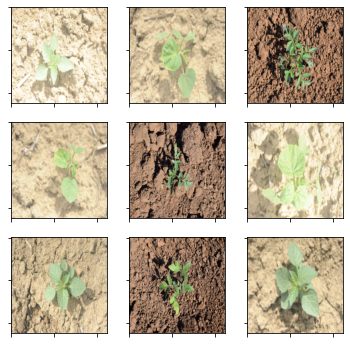

In [20]:
plot_sample(x)

### Data Augmentation + Visualization

In [21]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

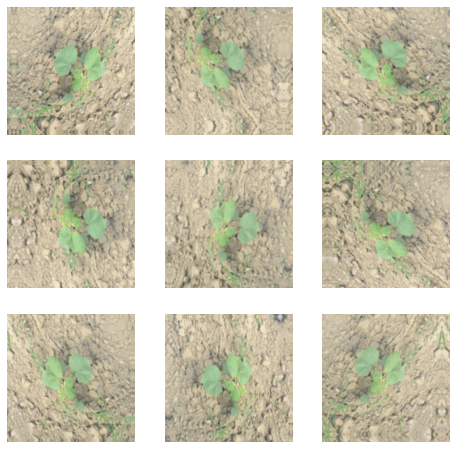

In [22]:
IMAGE_IX = 10
image = tf.expand_dims(x[IMAGE_IX], axis=0)

plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    aug_img = img_augmentation(image)
    plt.imshow(aug_img[0].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

In [23]:
def get_architecture(y, mobilenet_size, optimizer):
    """
    Given the parameters, it returns a compiled architecture (MobileNetV3)
    ready for training.
    """
    inputs = layers.Input(shape=INPUT_SHAPE)
    input_aug = img_augmentation(inputs)
    input_norm = layers.Lambda(mobilenet_v3.preprocess_input)(
        input_aug
    )  # placeholder in this case

    if mobilenet_size == "small":
        feature_extractor = MobileNetV3Small(
            weights="imagenet", include_top=False, input_tensor=input_norm
        )
    elif mobilenet_size == "large":
        feature_extractor = MobileNetV3Large(
            weights="imagenet", include_top=False, input_tensor=input_norm
        )

    # Create new model on top.
    feataures = layers.GlobalAveragePooling2D(name="pool")(
        feature_extractor.output
    )  # Flattening layer.
    fully = layers.Dense(units=64, activation="relu")(
        feataures
    )  # Add a fully connected layer.
    # Create a Classifier with shape=number_of_training_classes.
    fully = layers.Dropout(0.3)(fully)  # Regularize with dropout.
    out = layers.Dense(units=y.shape[1], activation="softmax")(fully)
    # This is the final model.
    model = Model(inputs, out)

    model.compile(
        loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )
    # model.summary()
    return model

#### Splitting the dataset

In [24]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=TEST_SPLIT, shuffle=True, stratify=y, random_state=RANDOM_STATE
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train,
    y_train,
    test_size=VAL_SPLIT,
    shuffle=True,
    stratify=y_train,
    random_state=RANDOM_STATE,
)

In [25]:
steps_per_epoch = len(x_train) // BATCH_SIZE

In [26]:
steps_per_epoch

78

#### Defining the Cyclical Learning Rate

In [27]:
clr = Triangular2CyclicalLearningRate(
    initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    step_size= STEP_SIZE_MULTIPLIER * steps_per_epoch 
)

#### Displaying how the Learning Rate is going to progress

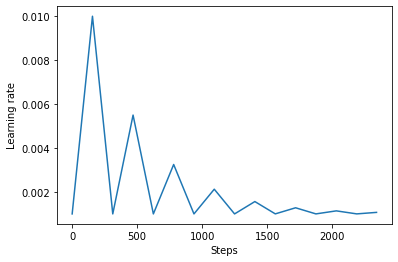

In [28]:
steps = np.arange(0, NUM_EPOCHS * steps_per_epoch)
lr = clr(steps)
plt.plot(steps, lr)
plt.xlabel("Steps")
plt.ylabel("Learning rate")
plt.show()

#### Training / Fine-Tuning Models

In [29]:
%%time
model = get_architecture(
    y, mobilenet_size="small", optimizer=tf.keras.optimizers.SGD(clr)
)

history_v3Small_cyclical = model.fit(
    x_train,  # train data
    y_train,  # labels
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=get_callbacks(WEIGHTS_FILE, NUM_EPOCHS // 2),
)

Epoch 1/30
79/79 [==============================] - 9s 45ms/step - loss: 1.3464 - accuracy: 0.3546 - val_loss: 1.2611 - val_accuracy: 0.4810
Epoch 2/30
79/79 [==============================] - 2s 32ms/step - loss: 1.0767 - accuracy: 0.5016 - val_loss: 1.1449 - val_accuracy: 0.5063
Epoch 3/30
79/79 [==============================] - 2s 30ms/step - loss: 0.8344 - accuracy: 0.6581 - val_loss: 1.1434 - val_accuracy: 0.4937
Epoch 4/30
79/79 [==============================] - 2s 31ms/step - loss: 0.7894 - accuracy: 0.7125 - val_loss: 1.0849 - val_accuracy: 0.5823
Epoch 5/30
79/79 [==============================] - 2s 29ms/step - loss: 0.7321 - accuracy: 0.7220 - val_loss: 0.9896 - val_accuracy: 0.5823
Epoch 6/30
79/79 [==============================] - 2s 31ms/step - loss: 0.6796 - accuracy: 0.7380 - val_loss: 0.8601 - val_accuracy: 0.6582
Epoch 7/30
79/79 [==============================] - 2s 31ms/step - loss: 0.6506 - accuracy: 0.7412 - val_loss: 0.7188 - val_accuracy: 0.7468
Epoch 8/30
79

In [30]:
model.load_weights(WEIGHTS_FILE)
final_accuracy_cyclical = model.evaluate(x_test, y_test, 
                                         verbose=0)[1]
print("*"*50)
print(f"Final MobileNetV3-Small-Cyclical Accuracy: {final_accuracy_cyclical}")
print("*"*50)
print()

**************************************************
Final MobileNetV3-Small-Cyclical Accuracy: 0.9797979593276978
**************************************************



In [31]:
%%time
model = get_architecture(y, mobilenet_size="small", optimizer=tf.keras.optimizers.SGD())

history_v3Small_non_cyclical = model.fit(
    x_train,  # train data
    y_train,  # labels
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=get_callbacks(WEIGHTS_FILE, NUM_EPOCHS // 2),
)

Epoch 1/30
79/79 [==============================] - 7s 41ms/step - loss: 1.1705 - accuracy: 0.5016 - val_loss: 1.1860 - val_accuracy: 0.4684
Epoch 2/30
79/79 [==============================] - 3s 33ms/step - loss: 0.9189 - accuracy: 0.6262 - val_loss: 1.0350 - val_accuracy: 0.5190
Epoch 3/30
79/79 [==============================] - 3s 32ms/step - loss: 0.7553 - accuracy: 0.6965 - val_loss: 0.9668 - val_accuracy: 0.5949
Epoch 4/30
79/79 [==============================] - 3s 33ms/step - loss: 0.6588 - accuracy: 0.7604 - val_loss: 0.7318 - val_accuracy: 0.7089
Epoch 5/30
79/79 [==============================] - 3s 32ms/step - loss: 0.5600 - accuracy: 0.7923 - val_loss: 0.5662 - val_accuracy: 0.7215
Epoch 6/30
79/79 [==============================] - 3s 32ms/step - loss: 0.4997 - accuracy: 0.8403 - val_loss: 0.2692 - val_accuracy: 0.9620
Epoch 7/30
79/79 [==============================] - 2s 30ms/step - loss: 0.4019 - accuracy: 0.8626 - val_loss: 0.4992 - val_accuracy: 0.7468
Epoch 8/30
79

In [32]:
%%time
model.load_weights(WEIGHTS_FILE)
final_accuracy_non_cyclycal = model.evaluate(x_test, y_test, batch_size=1, verbose=0)[1]
print("*" * 50)
print(f"Final MobileNetV3-Small Accuracy: {final_accuracy_non_cyclycal:.3f}")
print("*" * 50)
print()

**************************************************
Final MobileNetV3-Small Accuracy: 0.990
**************************************************

CPU times: user 1.9 s, sys: 46.5 ms, total: 1.95 s
Wall time: 1.8 s


#### Plotting Performances

In [33]:
# Preparing performances for being plotted
performances = [(f"Cyclical ({round(final_accuracy_cyclical, 3)})", 
                  history_v3Small_cyclical.history["val_accuracy"]),
                (f"Non-Cyclical ({round(final_accuracy_non_cyclycal, 3)})", 
                  history_v3Small_non_cyclical.history["val_accuracy"])]

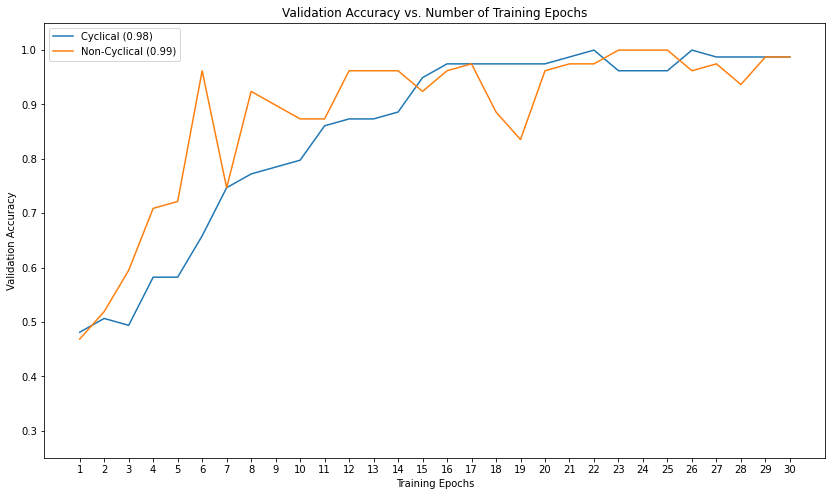

In [34]:
plot_performances(performances)

## Conclusions
Cyclical Learning Rate makes sense, but depending on other factors a standard scheduler can perform better.

## Possible Extensions
1. Use a different pre-trained network (for instance, MobileNetV3Large).
2. Try a different value for the STEP_SIZE_MULTIPLIER variable. Values ranging from 2 to 8 should work.
3. Try different epochs and batch sizes.

## Bibliography
[1] Smith, L.N. (2015). No More Pesky Learning Rate Guessing Games. ArXiv, abs/1506.01186.